* Taxi V3: https://gymnasium.farama.org/environments/toy_text/taxi/

# Libraries

In [1]:
import coax
import gymnasium
import haiku
import jax
import matplotlib.pyplot as pyplot

from jax             import numpy
from IPython.display import clear_output

/home/efren/.pyenv/versions/3.11.6/envs/pong/lib/python3.11/site-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/home/efren/.pyenv/versions/3.11.6/envs/pong/lib/python3.11/site-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/home/efren/.pyenv/versions/3.11.6/envs/pong/lib/python3.11/site-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/home/efren/.pyenv/versions/3.11.6/envs/pong/lib/python3.11/site-packages/flax/configurations.py:42: DeprecationWarning: jax.config.defi

# Environment

In [2]:
name = "pong"

environment = gymnasium.make("PongNoFrameskip-v4", render_mode="rgb_array")
environment = gymnasium.wrappers.AtariPreprocessing(environment)
environment = coax.wrappers.FrameStacking(environment, num_frames=3)
environment = gymnasium.wrappers.TimeLimit(environment, max_episode_steps=108000 // 3)
environment = coax.wrappers.TrainMonitor(environment, name=name, tensorboard_dir=f"./data/tensorboard/{name}")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


# Model

In [3]:
def shared(S, is_training):
    seq = haiku.Sequential([
        coax.utils.diff_transform,
        haiku.Conv2D(16, kernel_shape=8, stride=4), jax.nn.relu,
        haiku.Conv2D(32, kernel_shape=4, stride=2), jax.nn.relu,
        haiku.Flatten(),
    ])
    X = numpy.stack(S, axis=-1) / 255.
    return seq(X)


def func_pi(S, is_training):
    logits = haiku.Sequential((
        haiku.Linear(256), jax.nn.relu,
        haiku.Linear(environment.action_space.n, w_init=numpy.zeros),
    ))
    X = shared(S, is_training)
    return {'logits': logits(X)}


def func_v(S, is_training):
    value = haiku.Sequential((
        haiku.Linear(256), jax.nn.relu,
        haiku.Linear(1, w_init=numpy.zeros), numpy.ravel
    ))
    X = shared(S, is_training)
    return value(X)

In [4]:
pi = coax.Policy(func_pi, environment)
v  = coax.V(func_v, environment)

In [5]:
pi, v, pi_behavior, v_targ = coax.utils.load('checkpoint.pkl.lz4')

# Playthrough

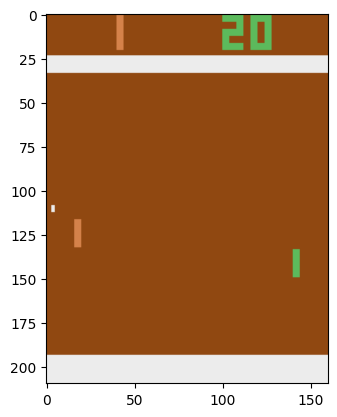

Steps taken: 1662
Final score: 20.0
Penalties:   0


In [6]:
state, _ = environment.reset()

score, steps, penalties, reward = 0, 0, 0, 0

done=False
while not done:
    steps += 1
    action = pi_behavior(state)
    state, reward, done, truncated, info = environment.step(action)
    score += reward
    if reward == -10:
        penalties += 1

    clear_output(wait=True)
    pyplot.imshow(environment.render())
    pyplot.show()

print(f"Steps taken: {steps}")
print(f"Final score: {score}")
print(f"Penalties:   {penalties}")